# Customer Churn Prediction

The goal of this project is to predict the loss of customers who stop using a company's products or services over a specific period (churn) based on behavior and history.

## Import necessary libraries

In [43]:
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


We will configure pandas to allow us to see all the columns when we are printing the output

In [11]:
pd.set_option('display.max_columns', None)

## Importing the dataset

In [12]:
dataset_path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Path to dataset:", dataset_path)

Path to dataset: /Users/shashanks/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


Before importing, it would be beneficial to include a custom missing value representations to target cases where ' ', 'NA', etc. are used to represent null values.

In [32]:
custom_missing_values = ["", " ", "NA", "N/A", "na", "n/a", "?", "None", "NULL", "null", "NaN", "nan"]

In [33]:
df = pd.read_csv(f"{dataset_path}/WA_Fn-UseC_-Telco-Customer-Churn.csv", na_values=custom_missing_values)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Cleaning

In [34]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Naming standardization

Let us first ensure standardization across the columns as some are written in lower camel case, upper camel case, and lowercase.

In [35]:
rename_dict = { "customerID" : "CustomerId",
                "gender" : "Gender", 
                "tenure" : "Tenure",
                "StreamingTV" : "StreamingTv"
                }

In [36]:
df.rename(columns=rename_dict, inplace=True)
df.head()

,CustomerId,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTv,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Missing values

Let us check for any missing values as it can introduce bias and have a significant effect on the conclusions that can be drawn from our dataset.

In [38]:
df.isnull().sum()

CustomerId           0
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
Tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTv          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

We can see that we have 11 null values in our `TotalCharges` column

In [56]:
df.loc[:, ["TotalCharges"]].describe()

,TotalCharges
count,7032.000000
mean,2283.300441
std,2266.771362
min,18.800000
25%,401.450000
50%,1397.475000
75%,3794.737500
max,8684.800000


We can see from the numerical summaries table above, that:
- As the mean > median (50%), the distribution of the `TotalCharges` column will be right-skewed
- As the standard deviation (std) ≈ mean, the data spans a broad range and there might be possible outliers
- As the max is more than double the 75% value, it suggests our data is right-skewed with possible outliers. This is similar to the conclusion we made in the previous 2 points as well

We can confirm the above statements by visualizing the distribution of the column.

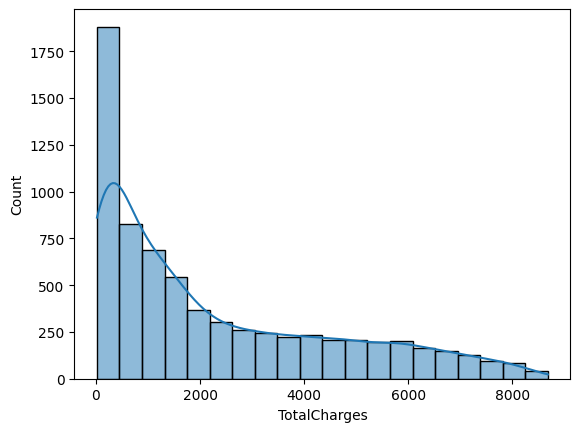

In [58]:
sns.histplot(df.loc[:, "TotalCharges"], kde=True, bins=20)
plt.show()

We can see that the data is positively skewed as we have a long right tail. This indicates that our customers likely may have had short tenures or low monthly charges.

This confirms what we have initially assumed from the numerical summaries table, as such we cannot proceed with mean imputation as the mean will be pulled up by the high-end outliers and we could end up overestimating missing values. Therefore, we will use the median imputation as the median is more representative of the "typical" value and is robust to outliers.

In [59]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [62]:
df.isnull().sum()

CustomerId          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTv         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Categorical Features

Now let's identify the categorical features and the numerical features in our data.

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerId        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTv       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [64]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features

['CustomerId',
 'Gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTv',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

Now we can look at the unique values in each of the categorical columns to see if there are any abnormal inputs

In [65]:
for col in categorical_features:
    print(f"Unique values in '{col}': {df[col].unique()}")

Unique values in 'CustomerId': ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in 'Gender': ['Female' 'Male']
Unique values in 'Partner': ['Yes' 'No']
Unique values in 'Dependents': ['No' 'Yes']
Unique values in 'PhoneService': ['No' 'Yes']
Unique values in 'MultipleLines': ['No phone service' 'No' 'Yes']
Unique values in 'InternetService': ['DSL' 'Fiber optic' 'No']
Unique values in 'OnlineSecurity': ['No' 'Yes' 'No internet service']
Unique values in 'OnlineBackup': ['Yes' 'No' 'No internet service']
Unique values in 'DeviceProtection': ['No' 'Yes' 'No internet service']
Unique values in 'TechSupport': ['No' 'Yes' 'No internet service']
Unique values in 'StreamingTv': ['No' 'Yes' 'No internet service']
Unique values in 'StreamingMovies': ['No' 'Yes' 'No internet service']
Unique values in 'Contract': ['Month-to-month' 'One year' 'Two year']
Unique values in 'PaperlessBilling': ['Yes' 'No']
Unique values in 'PaymentMethod': ['Electron

Let us first remove the `CustomerId` column as it is a unique customer identifier rather than a feature that would help us in predicting churn.

In [66]:
categorical_features.remove('CustomerId')
df.drop(columns=['CustomerId'], inplace=True)

We can see that there are a lot of categorical columns that can be encoded.